# Lab 2: Linear Models
This lab, like the others that follow it, will be a small, largely self-guided project in building a machine learning model.
You will write a logistic regression classifier, from scratch, to classify 28x28 pixel images of handwritten digits (0 - 9) by which digit appears in the image.
This is [the famous MNIST dataset](http://yann.lecun.com/exdb/mnist/), which has 60,000 training examples and 10,000 test examples.

In [2]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# Any other imports you need go here

## Section 0: download the data
Download the data as a CSV [here](https://pjreddie.com/projects/mnist-in-csv/) (the original data format is very unfriendly) and read the data format on the website.

## Section 1: load, understand, and preprocess the data
Load the data from disk into four numpy arrays: x_train (feature vectors from the training set), y_train (labels from the training set), x_test (feature vectors from the test set), and y_test (labels from the test set).

Then, do some simple preprocessing.
Normalize your features by subtracting the mean and dividing by the range.
This is less important for linear models, but is generally good practice and will be much more important with more complex models.
Make sure you don't use any values computed from the test set, just the mean and range of the training set.

Finally, display one of the training images, and print its correct label.

Functions to look at:
 - `np.loadtxt`
 - `np.reshape`
 - `plt.imshow`

In [25]:
# Your code here
train_data = np.loadtxt('../../data/lab_1_data/mnist_train.csv', delimiter=',')
test_data = np.loadtxt('../../data/lab_1_data/mnist_test.csv', delimiter=',')

In [26]:
# 60,000 images with 784 pixels each, first column is the labels (according to website)
print(np.shape(train_data))

(60000, 785)


In [27]:
y_train, x_train = np.split(train_data, [1], axis=1)
y_test, x_test = np.split(test_data, [1], axis=1)

In [28]:
print(np.shape(y_train))
print(np.shape(x_train))

print(np.shape(y_test))
print(np.shape(x_test))

(60000, 1)
(60000, 784)
(10000, 1)
(10000, 784)


In [29]:
print(y_train[:10])
print(y_test[:10])

[[5.]
 [0.]
 [4.]
 [1.]
 [9.]
 [2.]
 [1.]
 [3.]
 [1.]
 [4.]]
[[7.]
 [2.]
 [1.]
 [0.]
 [4.]
 [1.]
 [4.]
 [9.]
 [5.]
 [9.]]


In [40]:
# Preprocessing

# This is incorrect. We need the overall mean, not the means of each image. Otherwise, important deviations between
# the images would be left out of the data.
# # Get mean of each row (each image)
# means = np.mean(x_train, axis=1, keepdims=True)
# # Get range of each row
# ranges = np.ptp(x_train, axis=1, keepdims=True)

mean = np.mean(x_train)
trn_mean = mean * np.ones(x_train.shape)
tst_mean = mean * np.ones(x_test.shape)
dev = np.ptp(x_train)

print(mean, dev)

33.318421449829934 255.0


In [46]:
x_train = (x_train - trn_mean) / dev
x_test = (x_test - tst_mean) / dev

In [47]:
print(np.mean(x_train), np.mean(x_test))
print(np.ptp(x_train), np.ptp(x_test))

-9.292793292240034e-18 0.0018541295684940551
1.0 1.0


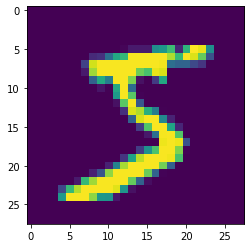

In [48]:
plt.imshow(np.reshape(x_train[0], (28, 28)))

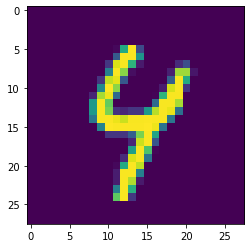

In [49]:
plt.imshow(np.reshape(x_train[30234], (28, 28)))

## Section 2: build a data pipeline
Make a pipeline that turns the dataset you have in numpy arrays into tensors that your model can use.
The pipeline should also shuffle and batch the data (with some reasonable batch size; I used 64 because I'm training on a GPU but you might want to go lower).

There are multiple ways to approach this.
No matter what, you'll need two `tf.data.Dataset`s, one for train and one for test, and probably you'll do some transforms to that.
I made datasets which did not use `repeat` -- you might instead repeat the data for as many epochs (full run-throughs of the dataset during training, ~5-10 for this assignment) as you plan to train for.

Optionally, you might want to cache or prefetch data to prevent it from being loaded multiple times while the model is training and keep the model from needing to wait for data.

Now might also be a good place to convert the labels to one-hot encoding (see below), though you don't need to.
If you want, you could also do your data normalization on-the-fly here (but make sure it still does the same thing).

I would also create `SummaryWriter`s for the train and test sets here.

Functions to look at (not exhaustive):
 - `tf.data.Dataset.from_tensor_slices`
 - `tf.data.Dataset.shuffle`
 - `tf.data.Dataset.batch`
 - `tf.data.Dataset.repeat`

In [50]:
n_epochs = 10
batch_size = 16

# .cache() saves 
dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))\
    .shuffle(500).batch(batch_size).cache()
dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))\
    .shuffle(500).batch(batch_size).cache()

train_writer = tf.summary.create_file_writer('../../logs/lab_1_logs/train')
test_writer = tf.summary.create_file_writer('../../logs/lab_1_logs/test')

## Section 3: build a model graph
This is where the actual model gets built.
I'll give you the steps, but there's flexibility in how you implement each part.
Make sure your design is clean, both for efficiency and ease of debugging.
Names help divide the model into logical parts.

Note that the first axis of every tensor will be the batch size.
So, a tensor that in your model is a scalar will likely have a shape of (?), and a 10-element vector will have a shape of (?, 10).
The "?" indicates that TensorFlow will treat this axis as being variable-length, since it can't infer it just from context.
It may be helpful to switch your thinking back and forth from one view (no batches, scalars are scalars) when thinking about modeling to another (scalars come in batches) when writing code that changes shapes.

If you're having difficulty debugging, try looking at your graph in TensorBoard, printing tensor objects to see their shapes, and running small parts of the graph while feeding values to certain tensors.

Functions to look at throughout:
 - `tf.cast`
 - `tf.expand_dims`
 - `tf.squeeze`
 - arithmetic operations

### 3.1: Class
Write a `tf.Module` class that will be your logistic regression model. You may want to implement your graph operations in the `__call__` method for convenience.

#### 3.1.1: Variables
Logistic regression needs two variables, correctly shaped: a weight matrix and a vector of biases. 

#### 3.1.2: Logits
Compute the inputs to the softmax functiton, the logits or "unnormalized probabilities." The result should be, for each example in the batch, a vector of ten values (so the tensor has a shape like (?, 10)).

#### 3.1.3: Softmax
Apply the softmax function to the logits to obtain a vector of class probabilities.
Again, there should be a probability for each class for each example.
Do _not_ use helper functions to compute the softmax function, like `tf.nn.softmax` or `tf.contrib.layers.softmax`.
Instead, stick to core operations like `tf.exp`.

Two main reasons for this:
 1. Better to learn without the API doing too much of the work for you; when doing model development it'll basically all be from scratch
 2. I couldn't get `tf.nn.softmax` to run on a GPU, so I'd do it this way in practice too

#### 3.1.4: Trace function
Write a trace function to export your graph to TensorBoard (or decorate the `__call__` method).

In [53]:
n_features = x_train.shape[1]
n_classes = 10

# Your code here
class LogisticRegression(tf.Module):
    def __init__(self, name=None):
        super().__init__(name)
        
        # Taking dot product with single feature vectors for the images
        # Uniform initializer?
        self.weights = tf.Variable(tf.initializers.glorot_uniform()(shape=(n_features, n_classes), dtype=tf.float64), \
                                   name='weights')
        # Scalar
        self.bias = tf.Variable(tf.zeros_initializer()(shape=(n_classes,), dtype=tf.float64), name='bias')
        
    # Don't understand decoration too well...
    # x should be a shape (n_features,) tensor representing a single image
    @tf.function
    def __call__(self, x):
        # A row vector of 10 logits l_i, one for each digit class
        # Can add tensor of shape (1, 10) to one of shape (10,)
        logits = tf.squeeze(tf.add(tf.matmul(tf.expand_dims(x, axis=0), self.weights), self.bias))
        exp = tf.exp(logits)
        probs = exp / tf.reduce_sum(exp)
        # Return a shape (10,) tensor of probabilities
        return probs

### 3.2: Cross-entropy loss
Compute the per-example cross-entropy loss $$L = -y \cdot \log p_\text{model}(y)$$ using the probabilities and the correct label.

Then, take the mean of the per-example losses to compute a per-batch loss.

It may be convenient to convert the label to a one-hot vector: 10 elements, each of which is 0 except the place of the correct label.
For instance, a label of "3" would be the vector $$[0, 0, 0, 1, 0, 0, 0, 0, 0, 0].$$

Functions to look at:
 - `tf.one_hot`
 - `tf.math.log`

In [63]:
# Your code here
def _loss(target, actual):
    # Shape should be (n_examples,) after this
    loss_per_example = -1 * tf.reduce_sum(tf.one_hot(tf.cast(target, dtype=tf.int32), 10) * tf.cast(tf.math.log(actual), dtype=tf.float32), axis=1)
    loss_batch = tf.reduce_mean(loss_per_example)
    return loss_batch

### 3.3: The optimizer
Add an optimizer (simple gradient descent is fine). You may need to play around with the learning rate to find one that works.

Write a train and test method that each represent one step of training/testing. The train method should apply the optimizer to minimize the per-batch loss. Also, add a summary operation which saves the per-batch loss so you can plot it later.

The model should predict the digit it assigns the highest probability. 
Add a tensor which represents what fraction of the batch the model predicted correctly (its accuracy, or average 0/1 loss), and a summary operation for accuracy.

You should record these summaries for both training and testing.


Functions to look at:
 - `tf.argmax`
 - `tf.equal`
 - `tf.reduce_mean`


In [65]:
# Add an optimizer to the graph
optimizer = tf.optimizers.SGD(1e-4)

def train(model, x, y, i):
    with tf.GradientTape() as g:
        loss = lambda: _loss(y, model(x))
    optimizer.minimize(loss, model.trainable_variables)
    with train_writer.as_default():
        tf.summary.scalar('loss', loss(), step=i)
        # tf.summary.scalar('bias', model.bias, step=i)

def test(model, x, y, i):
    loss = _loss(y, model(x))
    with test_writer.as_default():
        tf.summary.scalar('loss', loss, step=i)
    # We are returning loss because we want to print it during our training loop
    return loss

## Section 4: train the model
Make a training loop which iterates through the full training set multiple times, and, for each batch run the train method you wrote earlier. 

After each epoch, iterate over the test dataset and print the average test accuracy over the whole test set.
Finally, use a `Checkpoint` to save the whole graph to disk.

Remember to: 
 - Run your trace method once to export your graph to TensorBoard
 - Give train and test methods step numbers (batch steps)

Then, run training.
You should expect the model to hit about 90% test-set accuracy.
Not bad for a linear model!
If it doesn't, it might indicate a bug in your code, or you might need to tune hyperparameters (e.g. batch size, learning rate).
The accuracy should sharply jump after the first epoch, so you don't need to wait for the full model to train to know you have a bug. 

You might notice, looking at the training plots on TensorBoard, how close the training and test errors are.
This suggests our model is probably underfitting, and a more powerful model will do better.

<sup><sub>My model was showing 20% accuracy and it took over an hour to figure out I was actually just computing accuracy wrong :(</sub></sup>

In [66]:
model = LogisticRegression()
train_batch = 0
test_batch = 0

# Training loop
for i in range(n_epochs):
    # Iterate over dataset once
    for x, y in dataset_train:  
        if train_batch == 0:
            # On the first batch, run a full trace
            tf.summary.trace_on(graph=True, profiler=True)
            # We simply run this operation to add our graph to TensorBoard
            with train_writer.as_default():
                tf.summary.trace_export(name='first training batch', step=0, profiler_outdir='../../logs/lab_1_logs')
        # Call train iteration
        train(model, x, y, train_batch)
        train_batch += 1

    print('Epoch:\t', i)
    test_losses = [] # Track average loss over test set
    for x, y in dataset_test:
        test_losses.append(test(model, x, y, test_batch))
        # Roughly align test batches with training batches
        test_batch += 1

    print('Average Test Set Loss:\t', np.mean(test_losses))
    
# Save model
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.write('./checkpoints_lecture/model')

Epoch:	 0
Average Test Set Loss:	 8.207403
Epoch:	 1
Average Test Set Loss:	 8.188117
Epoch:	 2
Average Test Set Loss:	 8.176336
Epoch:	 3
Average Test Set Loss:	 8.16781
Epoch:	 4
Average Test Set Loss:	 8.161378
Epoch:	 5
Average Test Set Loss:	 8.156382
Epoch:	 6
Average Test Set Loss:	 8.152398
Epoch:	 7
Average Test Set Loss:	 8.14914
Epoch:	 8
Average Test Set Loss:	 8.146421
Epoch:	 9
Average Test Set Loss:	 8.144111


'./checkpoints_lecture/model'

## Section 5: use the model for inference
Pull one or more examples from the test set and display its image.
Then, use your model to predict what digit the image is, print that, and print the true label (which hopefully matches).

Remember you'll need to spin up a new instance of your model and checkpoint, then use `Checkpoint.restore()` to load the trained model before inference.

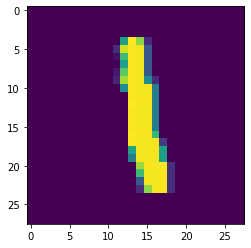

In [81]:
plt.imshow(np.reshape(x_train[6], (28, 28)))

In [79]:
new_model = LogisticRegression()
new_check = tf.train.Checkpoint(model=new_model)
new_check.restore('./checkpoints_lecture/model')

tf.print(model(x_train[3]), summarize=10)

[0.091510338149735332 0.12970479421532191 0.084003654964416877 0.11314319701535194 0.096734286146197682 0.10732009521930808 0.086778037843711908 0.10607878213050502 0.10571724258754038 0.079009571727911024]


## Section 6: visualizations
Visualize, as an image (i.e. `plt.imshow`), the weight matrix for each of the digits.
You might want to use the `vmin` and `vmax` arguments to put all of the matrices on the same scale. 
You'll need to load the weights again to save them to numpy arrays (by accessinging your class).

The results are pretty interesting.
The image should be brightest where the weights strongly indicate that digit, so you can see what's (linearly) characteristic of different digits -- I see a strong dark spot in the middle for zero, a distinctive curly tail on 2, and a consistent 3.
Other digits (e.g. 8 and 9) have much weaker patterns, suggesting greater variation in how people draw them.